TODO:
1) EDA
2) Run some training script (ready opensource solution)
3) Analyse results (confusion matrix, some exact cases)

In [58]:
!pip install -U transformers==4.46.3 evaluate==0.4.6 seqeval==1.2.2 datasets==3.1.0 transformers==4.46.3 torch torcheval torchmetrics torchvision

In [59]:
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
import numpy as np
from datasets import load_dataset, Dataset, DatasetDict
import evaluate
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    TrainingArguments,
    Trainer,
    DataCollatorForTokenClassification,
    BatchEncoding,
    set_seed,
)
import torch
import random
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import wandb
import os

os.environ["WANDB_DISABLED"] = "false"
wandb.init(mode="disabled")

–§–∏–∫—Å–∞—Ü–∏—è –≤—Å–µ—Ö RNG –¥–ª—è –≤–æ—Å–ø—Ä–æ–∏–∑–≤–æ–¥–∏–º–æ—Å—Ç–∏:

In [61]:
def set_all_seeds(seed: int):
    random.seed(seed)  # Python random seed
    np.random.seed(seed)  # NumPy random seed
    torch.manual_seed(seed)  # PyTorch CPU seed
    torch.cuda.manual_seed(seed)  # PyTorch CUDA seed
    torch.cuda.manual_seed_all(seed)  # For multi-GPU setups
    torch.backends.cudnn.deterministic = (
        True  # Ensure deterministic computation in cuDNN
    )
    torch.backends.cudnn.benchmark = (
        False  # Disable cuDNN auto-tuner for reproducibility
    )
    set_seed(seed)  # Hugging Face transformers seed setting


set_all_seeds(1337)

–í –∫–∞—á–µ—Å—Ç–≤–µ –¥–∞–Ω–Ω—ã—Ö –¥–ª—è —Ä–∞–±–æ—Ç—ã –±—ã–ª –≤—ã–±—Ä–∞–Ω –¥–∞—Ç–∞—Å–µ—Ç `Conll2012`

In [62]:
ds = load_dataset("ramybaly/conll2012")

–ó–∞—Ä–µ–≥–∏—Å—Ç—Ä–∏—Ä—É–µ–º –¥–æ–ø–æ–ª–Ω–∏—Ç–µ–ª—å–Ω—ã –º–µ—Ç–∞–¥–∞–Ω–Ω—ã–µ –æ —Ä–∞–∑–º–µ—Ç–∫–µ –¥–ª—è –∞–Ω–∞–ª–∏–∑–∞ –≤ –±—É–¥—É—â–µ–º (–º–∞–ø–ø–∏–Ω–≥ –Ω–µ –ø–æ—Å—Ç–∞–≤–ª—è–µ—Ç—Å—è —Å —Å–∞–º–∏–º –¥–∞—Ç–∞—Å–µ—Ç–æ, –≤–∑—è—Ç –∏–∑ —Å—Ç—Ä–∞–Ω–∏—Ü—ã –¥–∞—Ç–∞—Å–µ—Ç–∞):

In [63]:
LABEL_NAMES = [
    "O",
    "B-CARDINAL",  # –∫–æ–ª–∏—á–∏—Å—Ç–≤–µ–Ω–Ω—ã–µ —á–∏—Å–ª–∏—Ç–µ–ª—å–Ω—ã–µ: three, 200, one million, ...
    "B-DATE",  # –¥–∞—Ç—ã
    "B-EVENT",  # —Å–æ–±—ã—Ç–∏—è: Olympic games, Easter, ...
    "B-FAC",  # —Å–æ–æ—Ä—É–∂–µ–Ω–∏—è (facilities): Eiffel Tower, JFK airport, ...
    "B-GPE",  # –≥–µ–æ–ø–æ–ª–∏—Ç–∏—á–µ—Å–∫–∏–µ –æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏—è: New York, Texas, ...
    "B-LANGUAGE",  # —è–∑—ã–∫–∏: English, French, ...
    "B-LAW",  # –∑–∞–∫–æ–Ω—ã –∏ –Ω–æ—Ä–º–∞—Ç–∏–≤–Ω—ã–µ –∞–∫—Ç—ã: Constitution, Civil Rights Act, ...
    "B-LOC",  # –≥–µ–æ–≥—Ä–∞—Ñ–∏—á–µ—Å–∫–∏–µ –ª–æ–∫–∞—Ü–∏–∏: Mount Everest, Nile River, ...
    "B-MONEY",  # –¥–µ–Ω–µ–∂–Ω—ã–µ –≤—ã—Ä–∞–∂–µ–Ω–∏—è: $5, 10 euros, five million rubles
    "B-NORP",  # –Ω–∞—Ü–∏–æ–Ω–∞–ª—å–Ω–æ—Å—Ç–∏, —Ä–µ–ª–∏–≥–∏–∏, –ø–æ–ª–∏—Ç–∏—á–µ—Å–∫–∏–µ –≥—Ä—É–ø–ø—ã: Russians, Buddhists, Republicans, ...
    "B-ORDINAL",  # –ø–æ—Ä—è–¥–∫–æ–≤—ã–µ —á–∏—Å–ª–∏—Ç–µ–ª—å–Ω—ã–µ: first, second, third, ...
    "B-ORG",  # –æ—Ä–≥–∞–Ω–∏–∑–∞—Ü–∏–∏: Google, United Nations, ...
    "B-PERCENT",  # –ø—Ä–æ—Ü–µ–Ω—Ç—ã: 50%, twenty percent
    "B-PERSON",  # –∏–º–µ–Ω–∞ –ª—é–¥–µ–π: David Lynch, Maxim Kats, ...
    "B-PRODUCT",  # –ø—Ä–æ–¥—É–∫—Ç—ã –∏ –±—Ä–µ–Ω–¥—ã: Coca-Cola, Iphone, ...
    "B-QUANTITY",  # –∏–∑–º–µ—Ä—è–µ–º—ã–µ –≤–µ–ª–∏—á–∏–Ω—ã —Å –µ–¥–∏–Ω–∏—Ü–∞–º–∏: 5kg, 10 meters, ...
    "B-TIME",  # –≤—Ä–µ–º—è: 2 a.m., morning, ...
    "B-WORK_OF_ART",  # –ø—Ä–æ–∏–∑–≤–µ–¥–µ–Ω–∏—è –∏—Å–∫—É—Å—Å—Ç–≤–∞: Mona Lisa, –í–æ—Ä–æ–Ω–∏–Ω—ã, ...
    "I-CARDINAL",
    "I-DATE",
    "I-EVENT",
    "I-FAC",
    "I-GPE",
    "I-LANGUAGE",
    "I-LAW",
    "I-LOC",
    "I-MONEY",
    "I-NORP",
    "I-ORDINAL",
    "I-ORG",
    "I-PERCENT",
    "I-PERSON",
    "I-PRODUCT",
    "I-QUANTITY",
    "I-TIME",
    "I-WORK_OF_ART",
]

ENTITY_MAPPING = {i: ent for i, ent in enumerate(LABEL_NAMES)}

In [64]:
ds

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'tags'],
        num_rows: 115812
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'tags'],
        num_rows: 15680
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'tags'],
        num_rows: 12217
    })
})

In [65]:
ds_train = ds["train"].remove_columns(["id", "pos_tags"])
ds_val = ds["validation"].remove_columns(["id", "pos_tags"])
ds_test = ds["test"].remove_columns(["id", "pos_tags"])

df_train = ds_train.to_pandas()
df_val = ds_val.to_pandas()
df_test = ds_test.to_pandas()

–î–∞—Ç–∞—Å–µ—Ç

In [66]:
df_train

tokens  \
0                             [Big, Managers, on, Campus]   
1       [In, recent, years, ,, advanced, education, fo...   
2       [With, this, trend, ,, suddenly, the, mature, ...   
3       [In, order, to, attract, this, group, of, seas...   
4       [In, response, ,, each, year, over, 1000, matu...   
...                                                   ...   
115807  [In, fact, ,, Iraq, has, almost, sunk, into, a...   
115808  [The, same, day, ,, the, US, National, Broadca...   
115809  [Analysts, here, have, pointed, out, that, Ann...   
115810  [Calls, from, within, the, US, for, the, withd...   
115811  [On, the, 29th, and, 30th, of, this, month, ,,...   

                                                     tags  
0                                            [0, 0, 0, 0]  
1       [0, 2, 20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
2       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 27, 27...  
4       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...  
...                                                   ...  
115807  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
115808  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
115809  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
115810  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
115811  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  

[115812 rows x 2 columns]

In [67]:
classes_cnt = {}
for tag_arr in tqdm(df_train["tags"]):
    for cls_num in tag_arr:
        cls_name = ENTITY_MAPPING[cls_num]
        if cls_name != "O":
            cls_name = cls_name[2:]
        if cls_name not in classes_cnt:
            classes_cnt[cls_name] = 1
        else:
            classes_cnt[cls_name] += 1

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 115812/115812 [00:00<00:00, 133880.39it/s]


Text(0.5, 1.0, 'Token classes distribution in train dataset')

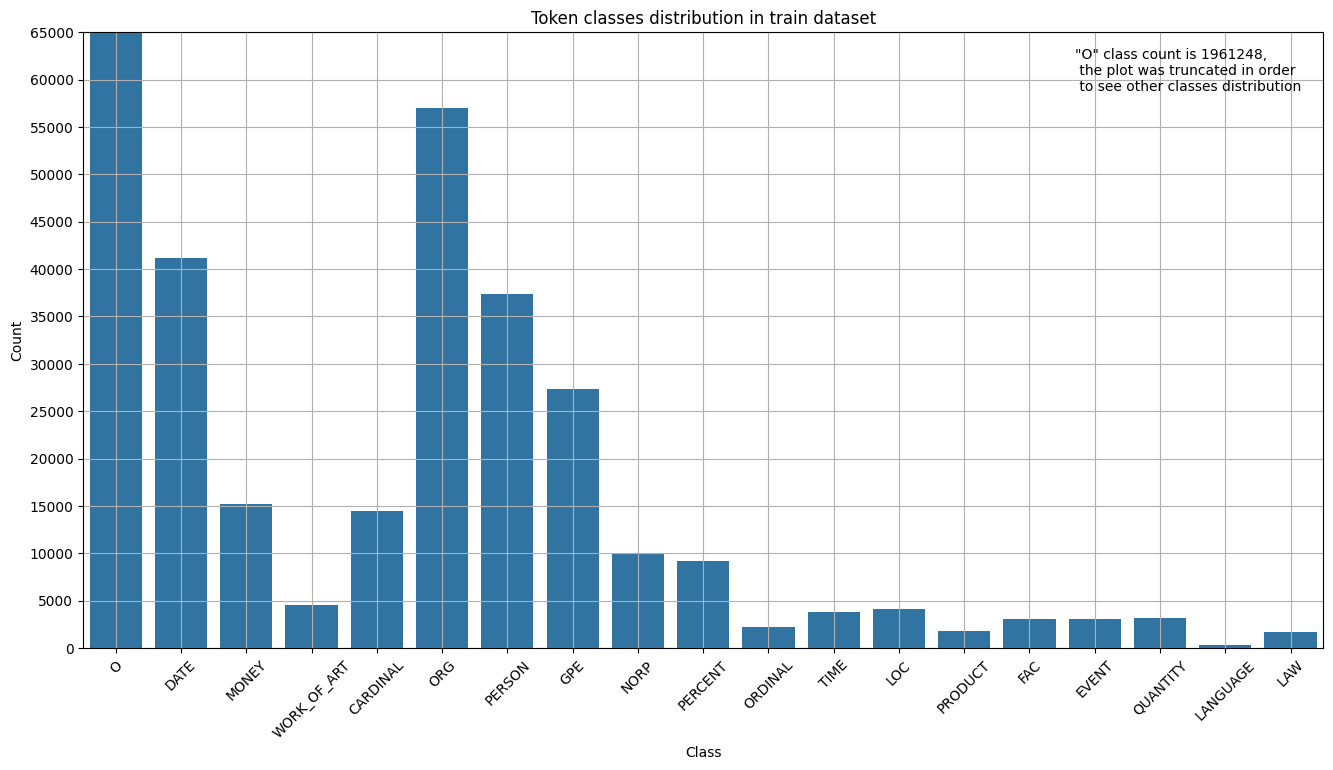

In [68]:
df = pd.DataFrame(list(classes_cnt.items()), columns=["Class", "Count"])

# Create the bar plot using Seaborn
plt.figure(figsize=(16, 8))  # Optional: Adjust figure size
sns.barplot(x="Class", y="Count", data=df)
plt.yticks(np.arange(0, max(df["Count"]) + 1, 5000))
plt.ylim((0, 0.065 * 1e6))
plt.xticks(rotation=45)
plt.text(
    0.80,
    0.90,
    f'"O" class count is {classes_cnt["O"]},\n the plot was truncated in order\n to see other classes distribution',
    horizontalalignment="left",
    verticalalignment="bottom",
    transform=plt.gca().transAxes,
    fontsize=10,
    color="black",
)
plt.grid(True)

# Add a title to the plot
plt.title("Token classes distribution in train dataset")

In [69]:
idx = 116
dict(
    zip(
        df_train.iloc[idx]["tokens"],
        [ENTITY_MAPPING[klass] for klass in df_train.iloc[idx]["tags"]],
    )
)

{'Last': 'B-DATE',
 'year': 'I-DATE',
 ',': 'O',
 'one': 'B-CARDINAL',
 'professor': 'O',
 'made': 'O',
 'a': 'O',
 'big': 'O',
 'hit': 'O',
 'with': 'O',
 'over': 'O',
 '30': 'B-CARDINAL',
 'students': 'O',
 'taking': 'O',
 'them': 'O',
 'to': 'O',
 'mainland': 'O',
 'China': 'B-GPE',
 'for': 'O',
 'ten': 'B-DATE',
 'days': 'I-DATE',
 'familiarize': 'O',
 'the': 'O',
 'investment': 'O',
 'environment': 'O',
 'there': 'O',
 '.': 'O'}

In [70]:
seq_lens = []
for tok_arr in tqdm(df_train["tokens"]):
    seq_lens.append(len(tok_arr))
avg_train_seqlen = sum(seq_lens) / len(seq_lens)
print("Train set:")
print(
    f"Min sentance length: {min(seq_lens):.2f}\nAvg sentance length: {avg_train_seqlen:.2f}\nMax sentance length: {max(seq_lens):.2f}\n"
)

seq_lens = []
for tok_arr in tqdm(df_val["tokens"]):
    seq_lens.append(len(tok_arr))
avg_train_seqlen = sum(seq_lens) / len(seq_lens)
print("Validation set:")
print(
    f"Min sentance length: {min(seq_lens):.2f}\nAvg sentance length: {avg_train_seqlen:.2f}\nMax sentance length: {max(seq_lens):.2f}\n"
)

seq_lens = []
for tok_arr in tqdm(df_test["tokens"]):
    seq_lens.append(len(tok_arr))
avg_train_seqlen = sum(seq_lens) / len(seq_lens)
print("Test set:")
print(
    f"Min sentance length: {min(seq_lens):.2f}\nAvg sentance length: {avg_train_seqlen:.2f}\nMax sentance length: {max(seq_lens):.2f}"
)

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 115812/115812 [00:00<00:00, 2600684.96it/s]


Train set:
Min sentance length: 1.00
Avg sentance length: 19.00
Max sentance length: 228.00



100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 15680/15680 [00:00<00:00, 2768890.48it/s]


Validation set:
Min sentance length: 1.00
Avg sentance length: 19.43
Max sentance length: 275.00



100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12217/12217 [00:00<00:00, 2351404.73it/s]

Test set:
Min sentance length: 1.00
Avg sentance length: 18.84
Max sentance length: 151.00


In [71]:
# TODO distro plot for lengths

### –ú–æ–¥–µ–ª—å


–î–ª—è –∑–∞–¥–∞—á–∏ –ø–æ–¥—Ö–æ–¥–∏—Ç –¥–µ–∫–æ–¥–µ—Ä–Ω–∞—è –º–æ–¥–µ–ª—å BERT —Å –¥–≤—É–Ω–∞–ø—Ä–∞–≤–ª–µ–Ω–Ω—ã–º attention-–º–µ—Ö–∞–Ω–∏–∑–º–æ–º.
![image.png](./_img/BERT.png)
–í –ø–∞–π–ø–ª–∞–π–Ω–µ –ø—Ä–∏–º–µ–Ω—è–µ—Ç—Å—è –ø—Ä–µ–¥–æ–±—É—á–µ–Ω–Ω–∞—è –º–æ–¥–µ–ª—å BERT, self-supervised –∑–∞–¥–∞—á–∞ –Ω–∞ –ø—Ä–µ—Ç—Ä–µ–Ω–∏—Ä–æ–≤–∫–µ —Å–æ—Å—Ç–æ–∏—Ç –∏–∑ 2 —á–∞—Å—Ç–µ–π - $MLM^1$ –∏ $NSP^2$:


1. 15% –ø—Ä–æ—Ü–µ–Ω—Ç–æ–≤ —Ç–æ–∫–µ–Ω–æ–≤ –º–∞—Å–∫–∏—Ä—É—é—Ç—Å—è, —Ç–æ –µ—Å—Ç—å –∑–∞–º–µ–Ω—è—é—Ç—Å—è –Ω–∞ [MASK]
2. –ë–∏–Ω–∞—Ä–Ω—ã–π –æ–±–¥–∂–µ–∫—Ç–∏–≤-–∏–Ω–¥–∏–∫—Ç–æ—Ä, —è–≤–ª—è—é—Ç—Å—è –¥–ª—è –∑–∞–∫–æ–ª–ª–µ–π—á–µ–Ω—ã—Ö –≤ 1 —Å—ç–º–ø–ª –ø—Ä–µ–ª–æ–∂–µ–Ω–∏—è —Ä–µ–∞–ª—å–Ω–æ –ø–æ—Å–ª–µ–¥–æ–≤–∞—Ç–µ–ª—å–Ω–æ –≤—Å—Ç—Ä–µ—á–∞—é—â–∏–º–∏—Å—è –≤ —Ç–µ–∫—Å—Ç–µ.

NER-–∑–∞–¥–∞—á–∞ —Å–≤–æ–¥–∏—Ç—Å—è –∫ –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏–∏ –∫–∞–∂–¥–æ–≥–æ —Ç–æ–∫–µ–Ω–∞, —á—Ç–æ –æ–∑–Ω–∞—á–∞–µ—Ç, —á—Ç–æ –±–æ–ª—å—à–µ –ø–æ–¥—Ö–æ–¥–∏—Ç –¥–∏—Å–∫—Ä–∏–º–∏–Ω–∞—Ç–∏–≤–Ω–∞—è –º–æ–¥–µ–ª—å, –µ–π –∏ —è–≤–ª—è–µ—Ç—Å—è BERT; —Å–ø–µ—Ü–∏—Ñ–∏–∫–∞ NER –∑–∞–¥–∞—á–∏ —Ç–∞–∫–∂–µ —Ç—Ä–µ–±—É–µ—Ç cased-—Ç–æ–∫–µ–Ω–∏–∑–∞—Ü–∏–∏, —Ç–∞–∫ –∫–∞–∫ –ø–æ—Ç–µ–Ω—Ü–∏–∞–ª—å–Ω–æ –ø–æ–º–æ–∂–µ—Ç –≤ –Ω–µ–∫–æ—Ç–æ—Ä—ã—Ö —Å–ª—É—á–∞—è—Ö –æ–ø—Ä–µ–¥–µ–ª–∏—Ç—å —Å–æ–±—Å—Ç–≤–µ–Ω–Ω—ã–µ –∏–º–µ–Ω–∞.

EDA –¥–∞—Ç–∞—Å–µ—Ç–∞ –ø–æ–∫–∞–∑—ã–≤–∞–µ—Ç –æ—Ü–µ–Ω–∫—É –¥–ª–∏–Ω—ã –≤ —Å–ª–æ–≤–∞—Ö, BPE, –∫–∞–∫ subword –º–µ—Ç–æ–¥, —É–≤–µ–ª–∏—á–∏–≤–∞–µ—Ç –¥–ª–∏–Ω—É –ø–æ—Å–ª–µ —Ç–æ–∫–µ–Ω–∏–∑–∞—Ü–∏–∏; —Ä–∞—Å–ø—Ä–æ—Å—Ç—Ä–∞–Ω–µ–Ω–Ω–æ–π –æ—Ü–µ–Ω–∫–æ–π —è–≤–ª—è–µ—Ç—Å—è $|text|_{words}\approx 0.75 \times |text|_{BPE-tokens}$

–¢–∞–∫ –∫–∞–∫ –º–∞–∫—Å–∏–º–∞–ª—å–Ω–æ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —Å–ª–æ–≤ –≤ –¥–∞—Ç–∞—Å–µ—Ç–µ 228, –¥–ª—è —Ç–æ–≥–æ, —á—Ç–æ–±—ã –≤—Å–µ —Ç–æ–∫–µ–Ω—ã —Ç–æ—á–Ω–æ –±—ã–ª–∏ –æ–±—Ä–∞–±–æ—Ç–∞–Ω—ã —Ç—Ä–µ–±—É–µ—Ç—Å—è $\lceil228/0.75\rceil = 304$, –¥–ª–∏–Ω—ã –ø—Ä–∏–Ω—è—Ç–æ –±—Ä–∞—Ç—å —Å—Ç–µ–ø–µ–Ω—è–º–∏ –¥–≤–æ–π–∫–∏, —Å–æ–æ—Ç–≤–µ—Ç—Å—Ç–≤–µ–Ω–Ω–æ –Ω—É–∂–Ω–∞ –º–æ–¥–µ–ª—å —Å $2^{\lceil\log_2 304\rceil} = 2^9 = 512$ —Ç–æ–∫–µ–Ω–æ–≤.

In [72]:
MODEL_NAME = "bert-base-cased"
MAX_LENGTH = 512
BATCH_SIZE = 32
NUM_EPOCHS = 5
LEARNING_RATE = 2e-5

In [73]:
ds_full = dataset = DatasetDict(
    {"train": ds_train, "validation": ds_val, "test": ds_test}
)

In [74]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [75]:
label2id = {label: i for i, label in enumerate(LABEL_NAMES)}
id2label = {i: label for i, label in enumerate(LABEL_NAMES)}

–†–∞–∑–º–µ—Ç–∫–∞ –¥–∞—Ç–∞—Å–µ—Ç–∞ –∏–º–µ–µ—Ç —Ç–∏–ø BIO, —Å—Ç–∞–Ω–¥–∞—Ä—Ç–Ω—ã–π –¥–ª—è NER. –û–¥–Ω–∞–∫–æ, –≤ –∏–∑–Ω–∞—á–∞–ª—å–Ω–æ–º –≤–∞—Ä–∏–∞–Ω—Ç–µ —Ä–∞–∑–º–µ—á–µ–Ω–æ –∫–∞–∂–¥–æ–µ —Å–ª–æ–≤–æ, –∫–æ—Ç–æ—Ä–æ–µ –¥–ª—è –º–æ–¥–µ–ª–∏ –º–æ–∂–µ—Ç —Å–æ—Å—Ç–æ—è—Ç—å –∏–∑ –Ω–µ—Å–∫–æ–ª—å–∫–∏—Ö —Ç–æ–∫–µ–Ω–æ–≤ –≤ —Å–∏–ª—É subword-—Ç–æ–∫–µ–Ω–∏–∑–∞—Ü–∏–∏, —Å–æ–æ—Ç–≤–µ—Ç—Å—Ç–≤–µ–Ω–Ω–æ, –Ω—É–∂–Ω–æ —Ç—Ä–∞–Ω—Å—Ñ–æ—Ä–º–∏—Ä–æ–≤–∞—Ç—å —Ä–∞–∑–º–µ—Ç–∫—É - —Ä–∞—Å–ø—Ä–æ—Ç—Ä–∞–Ω–∏—Ç—å –ª–µ–π–±–ª—ã —Å—É—â–Ω–æ—Å—Ç–µ–π –Ω–∞ –≤—Å–µ —Ç–æ–∫–µ–Ω—ã:
![image-2.png](./_img/NER2BPE.png)

In [76]:
def tokenize_and_align_labels(data, tok_kwargs, ignore_idx=-100):
    """
    –¢–æ–∫–µ–Ω–∏–∑–∞—Ü–∏—è —Ç–µ–∫—Å—Ç–∞ –∏ –≤—ã—Ä–∞–≤–Ω–∏–≤–∞–Ω–∏–µ –º–µ—Ç–æ–∫ —Å —É—á–µ—Ç–æ–º —Ä–∞–∑–¥–µ–ª–µ–Ω–∏—è –Ω–∞ –ø–æ–¥—Ç–æ–∫–µ–Ω—ã
    """
    tokenized_inputs = tokenizer(
        data["tokens"],
        **tok_kwargs,  # –ë—É–¥–µ–º –≤–æ–∑–≤—Ä–∞—â–∞—Ç—å —Å–ø–∏—Å–∫–∏, –∞ –Ω–µ —Ç–µ–Ω–∑–æ—Ä—ã
    )

    labels = []
    all_word_ids = []
    for i, label in enumerate(data["tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []

        for word_idx in word_ids:
            # –°–ø–µ—Ü–∏–∞–ª—å–Ω—ã–µ —Ç–æ–∫–µ–Ω—ã –ø–æ–ª—É—á–∞—é—Ç –º–µ—Ç–∫—É ignore_idx
            if word_idx is None:
                label_ids.append(ignore_idx)
            # –î–ª—è –ø–µ—Ä–≤–æ–≥–æ —Ç–æ–∫–µ–Ω–∞ –∫–∞–∂–¥–æ–≥–æ —Å–ª–æ–≤–∞ –∏—Å–ø–æ–ª—å–∑—É–µ–º —Å–æ–æ—Ç–≤–µ—Ç—Å—Ç–≤—É—é—â—É—é –º–µ—Ç–∫—É
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            # –î–ª—è –ø–æ–¥—Ç–æ–∫–µ–Ω–æ–≤ –∏—Å–ø–æ–ª—å–∑—É–µ–º –º–µ—Ç–∫—É ignore_idx –∏–ª–∏ –º–µ—Ç–∫—É —Ç–µ–∫—É—â–µ–≥–æ —Å–ª–æ–≤–∞ (–≤ –∑–∞–≤–∏—Å–∏–º–æ—Å—Ç–∏ –æ—Ç –∑–∞–¥–∞—á–∏)
            else:
                label_ids.append(ignore_idx)
            previous_word_idx = word_idx

        labels.append(label_ids)
        all_word_ids.append(word_ids)

    tokenized_inputs["labels"] = labels
    tokenized_inputs["word_ids"] = all_word_ids

    return tokenized_inputs

–ü–æ—Å–ª–µ –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–π subword-–º–æ–¥–µ–ª–∏ –ø–æ—Ç—Ä–µ–±—É–µ—Ç—Å—è –≤–æ—Å—Å—Ç–∞–Ω–æ–≤–∏—Ç—å —Ä–∞–∑–º–µ—Ç–∫—É –¥–æ word-—É—Ä–æ–≤–Ω—è:
![image.png](./_img/FUSEBERT2NERLabels.png)

In [ ]:
from collections import Counter


def align_predictions(
    tokenizer, raw_dataset, tokenized_dataset, predictions, id2label, max_length=512
):
    pred_label_ids = np.argmax(predictions, axis=-1)

    results = []

    for i in range(len(raw_dataset)):
        # –ü–æ–≤—Ç–æ—Ä–Ω–æ —Ç–æ–∫–µ–Ω–∏–∑–∏—Ä—É–µ–º –∏—Å—Ö–æ–¥–Ω—ã–µ —Ç–æ–∫–µ–Ω—ã, —á—Ç–æ–±—ã –ø–æ–ª—É—á–∏—Ç—å word_ids
        tokenized = tokenizer(
            raw_dataset[i]["tokens"],
            truncation=True,
            is_split_into_words=True,
            max_length=max_length,
            return_tensors=None,
        )

        word_ids = tokenized.word_ids()
        words = raw_dataset[i]["tokens"]
        true_labels = raw_dataset[i]["tags"]

        # –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è –∏–∑ –≥–æ—Ç–æ–≤–æ–≥–æ —Ç–æ–∫–µ–Ω–∏–∑–∏—Ä–æ–≤–∞–Ω–Ω–æ–≥–æ –¥–∞—Ç–∞—Å–µ—Ç–∞ (–≤ —Ç–æ–º –∂–µ –ø–æ—Ä—è–¥–∫–µ)
        pred_ids = pred_label_ids[i]
        word_to_preds = {}

        for token_idx, widx in enumerate(word_ids):
            if widx is None:
                continue
            word_to_preds.setdefault(widx, []).append(pred_ids[token_idx])

        aligned = []
        for widx, word in enumerate(words):
            preds_for_word = word_to_preds.get(widx, [])
            if preds_for_word:
                pred_id = Counter(preds_for_word).most_common(1)[0][0]
                pred_label = id2label[pred_id]
                if (
                    len(aligned)
                    and aligned[-1][1] == "O"
                    and pred_label.startswith("I")
                ):
                    pred_label = f"B{pred_label[1:]}"
            else:
                pred_label = "O"

            true_id = true_labels[widx]
            true_label = id2label[true_id] if true_id in id2label else str(true_id)

            aligned.append((word, pred_label, true_label))

        results.append(aligned)

    return results

In [77]:
tok_kwargs_analytical = {
    "truncation": False,
    "padding": False,
    "is_split_into_words": True,
    "return_tensors": None,
}

In [78]:
tokenized_datasets_analytical = dataset.map(
    lambda x: tokenize_and_align_labels(x, tok_kwargs_analytical, -100),
    batched=True,
    remove_columns=dataset["train"].column_names,
)

In [79]:
for stage in tokenized_datasets_analytical.keys():
    print(
        f"Max BPE-token length of sample in {stage} split:",
        max(
            tokenized_datasets_analytical[stage]
            .to_pandas()["input_ids"]
            .apply(lambda x: len(x))
        ),
    )

Max BPE-token length of sample in train split: 270
Max BPE-token length of sample in validation split: 353
Max BPE-token length of sample in test split: 171


–§–∞–∫—Ç–∏—á–µ—Å–∫–∞—è –ø—Ä–æ–≤–µ—Ä–∫–∞ –ø–æ–∫–∞–∑—ã–≤–∞–µ—Ç, —á—Ç–æ –µ—Å—Ç—å –ø–æ—Å–ª–µ–¥–æ–≤–∞—Ç–µ–ª—å–Ω–æ—Å—Ç–∏ $256\lt|text|_{BPE-tokens}$, –ø—Ä–∏ —ç—Ç–æ–º $\forall text\in Data: |text|_{BPE-tokens}\lt512$, –¥–ª–∏–Ω—É –Ω—É–∂–Ω–æ –ø–æ–¥–¥–µ—Ä–∂–∏–≤–∞—Ç—å –Ω–∞ —É—Ä–æ–≤–Ω–µ 512 BPE-—Ç–æ–∫–µ–Ω–æ–≤.

In [80]:
del tokenized_datasets_analytical

–î–ª—è –∫–æ–Ω—Å–∏—Å—Ç–µ–Ω–∏–Ω–æ—Å—Ç–∏, —É–±–µ–¥–∏–≤—à–∏—Å—å –≤ –ø—Ä–∞–≤–∏–ª–Ω–æ—Å—Ç–∏ –æ—Ü–µ–Ω–∫–∏, –±—É–¥–µ–º –ø–æ–¥–¥–µ—Ä–∂–∏–≤–∞—Ç—å —Å–ª–µ–¥—É—é—â–∏–µ –ø–∞—Ä–∞–º–µ—Ç—Ä—ã —Ç–æ–∫–µ–Ω–∏–∑–∞—Ü–∏–∏:

In [81]:
tok_kwargs = {
    "truncation": True,
    "padding": True,
    "is_split_into_words": True,
    "max_length": MAX_LENGTH,
    "return_tensors": None,
}

In [82]:
tokenized_datasets = dataset.map(
    lambda x: tokenize_and_align_labels(x, tok_kwargs, -100),
    batched=True,
    remove_columns=dataset["train"].column_names,
)

Map:   0%|          | 0/15680 [00:00<?, ? examples/s]

In [83]:
model = AutoModelForTokenClassification.from_pretrained(
    MODEL_NAME, num_labels=len(LABEL_NAMES), id2label=id2label, label2id=label2id
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [84]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer, padding=True)

In [85]:
metric = evaluate.load("seqeval")

In [86]:
def compute_metrics(p, ignore_index=-100):
    """
    –í—ã—á–∏—Å–ª–µ–Ω–∏–µ –º–µ—Ç—Ä–∏–∫ (precision, recall, f1) –¥–ª—è NER
    """
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # –£–±–∏—Ä–∞–µ–º —Å–ø–µ—Ü–∏–∞–ª—å–Ω—ã–µ —Ç–æ–∫–µ–Ω—ã (–º–µ—Ç–∫–∞ -100)
    true_predictions = [
        [LABEL_NAMES[p] for (p, l) in zip(prediction, label) if l != ignore_index]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [LABEL_NAMES[l] for (p, l) in zip(prediction, label) if l != ignore_index]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [ ]:
training_args = TrainingArguments(
    output_dir="./ner-model",
    evaluation_strategy="epoch",
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=NUM_EPOCHS,
    weight_decay=0.01,
    save_strategy="epoch",
    logging_dir="./logs",
    push_to_hub=False,
    report_to=None,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1",
    greater_is_better=True,
    save_total_limit=1,
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of ü§ó Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=lambda x: compute_metrics(x, -100),
)

/tmp/ipykernel_38/3442625466.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked t

TrainOutput(global_step=9050, training_loss=0.05365257946825818, metrics={'train_runtime': 13850.3431, 'train_samples_per_second': 41.808, 'train_steps_per_second': 0.653, 'total_flos': 7.449716308349784e+16, 'train_loss': 0.05365257946825818, 'epoch': 5.0})

In [ ]:
trainer.save_model("./ner-final-model-5-epochs")

## –í–∞–ª–∏–¥–∞—Ü–∏—è

In [87]:
# predictions = trainer.predict(tokenized_datasets["test"])
model_path = "/content/drive/MyDrive/model_5_epochs_len_512"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForTokenClassification.from_pretrained(
    model_path, num_labels=len(LABEL_NAMES), id2label=id2label, label2id=label2id
)

label_names = ds_test.features["tags"].feature.names

In [88]:
trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

predictions, labels, _ = trainer.predict(tokenized_datasets["test"])
predicted_label_ids = np.argmax(predictions, axis=-1)

/tmp/ipython-input-1267966716.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [89]:
tokenized_datasets["test"]

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels', 'word_ids'],
    num_rows: 12217
})

In [ ]:
aligned = align_predictions(
    tokenizer,
    dataset["test"],
    tokenized_datasets["test"],
    predictions,
    model.config.id2label,
    max_length=MAX_LENGTH,
)

In [92]:
aligned[0]

[('Powerful', 'O', 'B-WORK_OF_ART'),
 ('Tools', 'O', 'I-WORK_OF_ART'),
 ('for', 'O', 'I-WORK_OF_ART'),
 ('Biotechnology', 'O', 'I-WORK_OF_ART'),
 ('-', 'O', 'I-WORK_OF_ART'),
 ('Biochips', 'O', 'I-WORK_OF_ART')]

In [93]:
all_preds = [list(map(lambda tuple_: tuple_[1], list_)) for list_ in aligned]
all_gt = [list(map(lambda tuple_: tuple_[2], list_)) for list_ in aligned]

In [94]:
def bio2bo(label):
    if label == "O":
        return "O"
    return label.split("-")[1] if "-" in label else label


def make_NER_CF(true_labels, pred_labels, label2id):
    all_bo_labels = {bio2bo(label) for label in label2id.keys()}
    bo_label2id = {bio2bo(k): i for i, k in enumerate(all_bo_labels)}
    matrix = np.zeros((len(all_bo_labels), len(all_bo_labels)), dtype=int)

    for true_seq, pred_seq in zip(true_labels, pred_labels):
        for t, p in zip(true_seq, pred_seq):
            t_bo = bio2bo(t)
            p_bo = bio2bo(p)
            matrix[bo_label2id[t_bo], bo_label2id[p_bo]] += 1

    matrix[bo_label2id["O"], bo_label2id["O"]] = 0

    return matrix, all_bo_labels


def plot_cf(matrix, labels, make_zero_diag=False):
    plt.figure(figsize=(11 - 1, 9 + 1))
    matrix_ = matrix.copy()

    if make_zero_diag:
        np.fill_diagonal(matrix_, 0)

    sns.heatmap(
        matrix_,
        annot=True,
        fmt="d",
        xticklabels=labels,
        yticklabels=labels,
        cmap="Reds",
    )
    plt.xlabel("Predicted Entity")
    plt.ylabel("True Entity")
    plt.title("NER Word-level Confusion Matrix")
    plt.show()

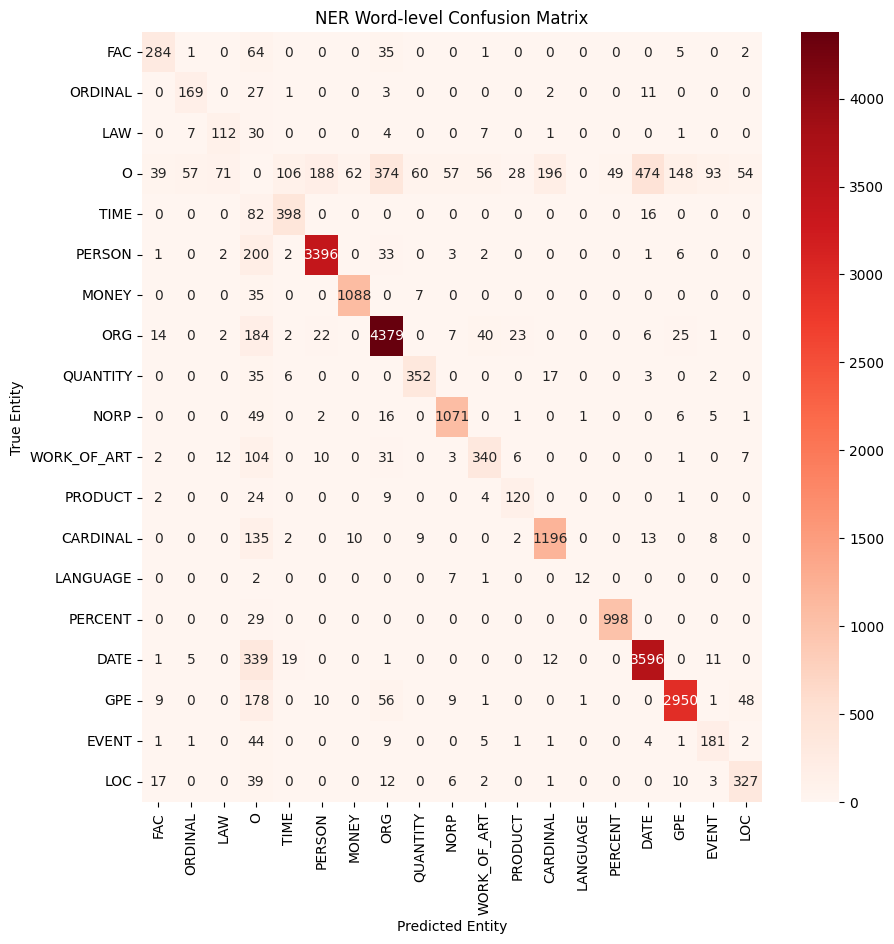

In [95]:
plot_cf(*make_NER_CF(all_gt, all_preds, label2id))

–†–∞—Å—Å–º–æ—Ç—Ä–µ–≤ Confusion Matrix –º—ã –º–æ–∂–µ–º –æ—Ç–º–µ—Ç–∏—Ç—å –Ω–µ—Å–∫–æ–ª—å–∫–æ —Ç–µ–Ω–¥–µ–Ω—Ü–∏–π –Ω–µ—É–¥–∞—á–Ω–æ–≥–æ —Ä–∞—Å—Å–ø–æ–∑–Ω–æ–≤–∞–Ω–∏—è —Å—É—â–Ω–æ—Å—Ç–µ–π (–ø—Ä–∏ —ç—Ç–æ–º –∑–∞–Ω—É–ª–µ–Ω —Å—á–µ—Ç—á–∏–∫ –ø—Ä–∞–≤–∏–ª—å–Ω—ã—Ö –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–π `Outside`-`Outside` –¥–ª—è –±–æ–ª–µ–µ –ø–ª–∞–≤–Ω–æ–π –∏–Ω–¥–∏–∫–∞—Ü–∏–∏ –æ—à–∏–±–æ–∫ heatmap'–æ–º):
1. –°—É—â–Ω–æ—Å—Ç—å `Time` —á–∞—Å—Ç–æ –æ—à–∏–±–æ—á–Ω–æ –∫–ª–∞—Å—Å–∏—Ñ–∏—Ü–∏—Ä—É–µ—Ç—Å—è –∫–∞–∫ `Outside`; –∞ —Ç–∞–∫–∂–µ –ª–æ–≥–∏—á–Ω–∞—è –æ—à–∏–±–∫–∞ –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏–∏ `Time` $\leftrightarrow$ `Date`
2. –ü–æ–º–∏–º–æ —É–ø–æ–º—è–Ω—É—Ç–æ–π –æ—à–∏–±–∫–∏, `Date` —á–∞—Å—Ç–æ –Ω–µ –æ–±–Ω–∞—Ä—É–∂–∏–≤–∞–µ—Ç—Å—è –∏ –æ—à–∏–±–æ—á–Ω–æ —Ä–∞–∑–º–µ—á–∞–µ—Ç—Å—è –∫–∞–∫ `Outside`
3. `Law` —á–∞—Å—Ç–æ –æ—à–∏–±–æ—á–Ω–æ –∫–ª–∞—Å—Å–∏—Ñ–∏—Ü–∏—Ä—É–µ—Ç—Å—è –∫–∞–∫ `Outside` –∏ –æ–±—Ä–∞—Ç–Ω–æ, —Ç–æ –µ—Å—Ç—å –º–æ–¥–µ–ª—å –≤ —Ü–µ–ª–æ–º –æ–±–ª–∞–¥–∞–µ—Ç –Ω–∏–∑–∫–∏–º –ø–æ–Ω–∏–º–∞–Ω–∏–µ–º —ç—Ç–æ–≥–æ –∫–ª–∞—Å—Å–∞
4. `Language` —á–∞—Å—Ç–æ –∫–ª–∞—Å—Å–∏—Ñ–∏—Ü–∏—Ä–æ–≤–∞–ª—Å—è –º–æ–¥–µ–ª—å—é –∫–∞–∫ `Norp`, –ø—Ä–∏ —ç—Ç–æ–º –≤–∑–∞–∏–º–Ω—ã—Ö –æ—à–∏–±–æ–∫ —Å `Outside` –ø–æ—á—Ç–∏ –Ω–µ—Ç; —Å–µ–º–∞–Ω—Ç–∏—á–µ—Å–∫–∞—è —Ä–æ–ª—å `Norp` –∏ `Language` –º–æ–∂–µ—Ç –±—ã—Ç—å —Å—Ö–æ–∂–∞, —á—Ç–æ –æ–±—ä—è—Å–Ω—è–µ—Ç –æ—à–∏–±–∫—É (—Ç–∞–∫–∂–µ —á–∞—Å—Ç–æ —Ç–æ–∫–µ–Ω—ã —Å—Ö–æ–∂–∏ –∏–∑-–∑–∞ –º–µ—Ö–∞–Ω–∏–∑–º–∞ —Å–ª–æ–≤–æ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏—è –∞–Ω–≥–ª–∏–π—Å–∫–æ–≥–æ —è–∑—ã–∫–∞ - –ø—Ä–∏–º. English –º–æ–∂–µ—Ç –≤—Å—Ç—Ä–µ—á–∞—Ç—å—Å—è –≤ –∫–æ–Ω—Ç–µ–∫—Å—Ç–µ –Ω–∞—Ü–∏–æ–Ω–∞–ª—å–Ω–æ—Å—Ç–∏ –∏–ª–∏ —è–∑—ã–∫–∞), —Ç–∞–∫ –∫–∞–∫ –æ—á–µ–Ω—å –º–∞–ª–∞ –≤—Å—Ç—Ä–µ—á–∞–µ–º–æ—Å—Ç—å –∫–ª–∞—Å—Å–∞, –º–æ–¥–µ–ª—å, —Å–∫–æ—Ä–µ–µ –≤—Å–µ–≥–æ, –Ω–µ –Ω–∞—É—á–∏–ª–∞—Å—å —Ä–∞–∑–¥–µ–ª—è—Ç—å –∏—Ö.
5. –ü–æ—Ö–æ–∂–∞—è –æ—à–∏–±–∫–∞ –≤–æ–∑–Ω–∏–∫–∞–µ—Ç —É —Å—É—â–Ω–æ—Å—Ç–µ–π –∫–ª–∞—Å—Å–æ–≤ `Cardinal` –∏ `Date`, –Ω–æ –≤ –ø—Ä–æ—Ü–µ–Ω—Ç–Ω–æ–º —Å–æ–æ—Ç–Ω–æ—à–µ–Ω–∏–∏ —ç—Ç–∞ –¥–æ–ª—è –º–∞–ª–∞ –¥–ª—è –æ–±–æ–∏—Ö –∫–ª–∞—Å—Å–æ–≤, —á—Ç–æ –¥–∞–µ—Ç –æ—Å–Ω–æ–≤–∞–Ω–∏—è –ø–æ–ª–∞–≥–∞—Ç—å, —á—Ç–æ –ø—Ä–æ–±–ª–µ–º–∞ –∏—Å—Ö–æ–¥–∏—Ç –∏–∑ –Ω–∏–∑–∫–æ–≥–æ –∫–æ–ª–∏—á–µ—Å—Ç–≤–∞ —Å—ç–º–ø–ª–æ–≤, —Ç–∞–∫ –∫–∞–∫ `Cardinal` –∏ `Date` –Ω–∞–º–Ω–æ–≥–æ –±–æ–ª–µ–µ —Ä–∞—Å–ø—Ä–æ—Å—Ç—Ä–∞–Ω–µ–Ω—ã –∏ –º–æ–¥–µ–ª—å –ª—É—á—à—â–µ –Ω–∞—É—á–∏–ª–∞—Å—å –∏—Ö —Ä–∞–∑–¥–µ–ª—è—Ç—å.

–î–ª—è –±–æ–ª—å—à–µ–π –Ω–∞–≥–ª–æ—è–¥–Ω–æ—Å—Ç–∏ –∑–∞–ø–æ–ª–Ω–∏–º –¥–∏–∞–≥–æ–Ω–∞–ª—å –Ω—É–ª—è–º–∏ (—Ç–∞–∫–∂–µ –¥–ª—è –±–æ–ª–µ–µ –ø—Ä–æ–∑—Ä–∞—á–Ω–æ–π –∏–Ω–¥–∏–∫–∞—Ü–∏–∏ heatmap'–æ–º):

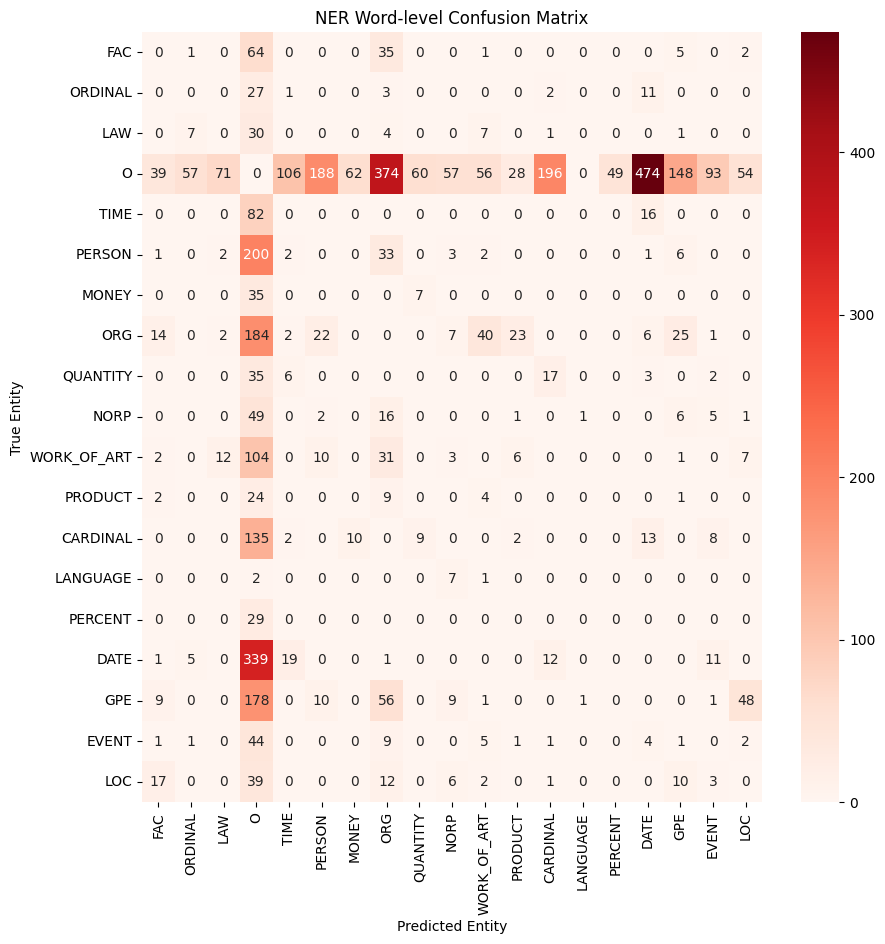

In [96]:
plot_cf(*make_NER_CF(all_gt, all_preds, label2id), True)

–ï—Å–ª–∏ —Ä–∞—Å—Å–º–∞—Ç—Ä–∏–≤–∞—Ç—å –æ—à–∏–±–∫–∏ –º–µ–∂–¥—É –∫–ª–∞—Å—Å–∞–º–∏, —Ç–æ –Ω–∞–≥–ª—è–¥–Ω–æ –≤–∏–¥–Ω–æ, —á—Ç–æ –±–æ–ª—å—à–∞—è —á–∞—Å—Ç—å –ø—Ä–∏—Ö–æ–¥–∏—Ç—Å—è –Ω–∞ `Outside`-`<ANY ENTITY>`, –∞ —Ç–∞–∫ –∫–∞–∫ `Outside` - —ç—Ç–æ "—Ñ–æ–Ω–æ–≤—ã–π" –∫–ª–∞—Å—Å, –º–æ–∂–Ω–æ –≤—ã—Å–∫–∞–∑–∞—Ç—å –ø—Ä–µ–¥–ø–æ–ª–æ–∂–µ–Ω–∏–µ, —á—Ç–æ —É –º–æ–¥–µ–ª–∏ –µ—Å—Ç—å –æ–±—â–∞—è –ø—Ä–æ–±–ª–µ–º–∞ —Å –¥–µ—Ç–µ–∫—Ü–∏–µ–π –∫–ª–∞—Å—Å–æ–≤, —É—Å–∏–ª–∏–≤–∞—é—â–∞—è—Å—è —Å —Ä–µ–¥–∫–æ—Å—Ç—å—é –∫–∞–∂–¥–æ–≥–æ –∫–æ–Ω–∫—Ä–µ—Ç–Ω–æ–≥–æ –∫–ª–∞—Å—Å–∞.

–†–∞—Å—Å–º–æ—Ç—Ä–∏–º –º–µ—Ç—Ä–∏–∫–∏ –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏–∏ –ø–æ –∫–∞–∂–¥–æ–º—É –∫–ª–∞—Å—Å—É –∏ –≤ –æ–±—à–µ–π —Å–æ–≤–æ–∫—É–ø–Ω–æ—Å—Ç–∏:

In [97]:
results = metric.compute(predictions=all_preds, references=all_gt)


print("Overall Metrics:")
print(f"Precision: {results['overall_precision']:.4f}")
print(f"Recall: {results['overall_recall']:.4f}")
print(f"F1-Score: {results['overall_f1']:.4f}")
print(f"Accuracy: {results['overall_accuracy']:.4f}")

print("\nDetailed Metrics per class:")
for key in results:
    if key not in [
        "overall_precision",
        "overall_recall",
        "overall_f1",
        "overall_accuracy",
    ]:
        print(f"\n{key}:")
        print(f"  Precision: {results[key]['precision']:.4f}")
        print(f"  Recall: {results[key]['recall']:.4f}")
        print(f"  F1-Score: {results[key]['f1']:.4f}")

Overall Metrics:
Precision: 0.8383
Recall: 0.8639
F1-Score: 0.8509
Accuracy: 0.9780

Detailed Metrics per class:

CARDINAL:
  Precision: 0.7994
  Recall: 0.8209
  F1-Score: 0.8100

DATE:
  Precision: 0.8023
  Recall: 0.8539
  F1-Score: 0.8273

EVENT:
  Precision: 0.5514
  Recall: 0.6941
  F1-Score: 0.6146

FAC:
  Precision: 0.6014
  Recall: 0.5973
  F1-Score: 0.5993

GPE:
  Precision: 0.9175
  Recall: 0.9002
  F1-Score: 0.9088

LANGUAGE:
  Precision: 0.8571
  Recall: 0.5455
  F1-Score: 0.6667

LAW:
  Precision: 0.5000
  Recall: 0.5909
  F1-Score: 0.5417

LOC:
  Precision: 0.6695
  Recall: 0.7349
  F1-Score: 0.7007

MONEY:
  Precision: 0.8591
  Recall: 0.8930
  F1-Score: 0.8757

NORP:
  Precision: 0.8782
  Recall: 0.9101
  F1-Score: 0.8938

ORDINAL:
  Precision: 0.7042
  Recall: 0.8164
  F1-Score: 0.7562

ORG:
  Precision: 0.8541
  Recall: 0.8916
  F1-Score: 0.8724

PERCENT:
  Precision: 0.8505
  Recall: 0.8922
  F1-Score: 0.8708

PERSON:
  Precision: 0.9030
  Recall: 0.9030
  F1-Score:

–ú–µ—Ç—Ä–∏–∫–∏ –ø–æ–¥—Ç–≤–µ—Ä–∂–¥–∞—é—Ç —Ä–∞–Ω–µ–µ —Å–¥–µ–ª–∞–Ω–Ω—ã–µ –≤—ã–≤–æ–¥—ã, —Ç–∞–∫–∂–µ –º–æ–∂–Ω–æ –æ—Ç–º–µ—Ç–∏—Ç—å –Ω–æ–≤—ã–µ —É—è–∑–≤–∏–º—ã–µ –º–µ—Å—Ç–∞. –ü—Ä–∏ —ç—Ç–æ–º —Å—Ä–µ–¥–Ω–∏–µ –º–µ—Ç—Ä–∏–∫–∏ –≤—ã—Å–æ–∫–∏.

In [107]:
from scipy.stats import spearmanr

counts = []
p_scores = []
r_scores = []
f1_scores = []

for key, cnt in classes_cnt.items():
    if key != "O":
        counts.append(cnt)
        p_scores.append(results[key]["precision"])
        r_scores.append(results[key]["recall"])
        f1_scores.append(results[key]["f1"])

print(
    "Count-Precision Spearman correlation: œÅ={:.3f} with p_val={:.3f} ".format(
        *spearmanr(counts, p_scores)
    )
)
print(
    "Count-Recall Spearman correlation: œÅ={:.3f} with p_val={:.3f} ".format(
        *spearmanr(counts, r_scores)
    )
)
print(
    "Count-F1 Spearman correlation: œÅ={:.3f} with p_val={:.3f} ".format(
        *spearmanr(counts, f1_scores)
    )
)

Count-Precision Spearman correlation: œÅ=0.614 with p_val=0.007 
Count-Recall Spearman correlation: œÅ=0.806 with p_val=0.000 
Count-F1 Spearman correlation: œÅ=0.773 with p_val=0.000 


–ö–æ—Ä—Ä–µ–ª—è—Ü–∏–∏ –ø–æ–∫–∞–∑—ã–≤–∞—é—Ç –ø—Ä–æ—á–Ω—É—é –ø—Ä—è–º—É—é —Å–≤—è–∑—å –≤–æ–∑–º–æ–∂–Ω–æ—Å—Ç–∏ –æ–±–Ω–∞—Ä—É–∂–µ–Ω–∏—è –∫–ª–∞—Å—Å–æ–≤ –∏ –∏—Ö —á–∞—Å—Ç–æ—Ç–æ–π –≤ —Ç—Ä–µ–Ω–∏—Ä–æ–≤–æ—á–Ω–æ–º –Ω–∞–±–æ—Ä–µ.

–í–æ–∑–º–æ–∂–Ω—ã–º –≤–∞—Ä–∏–∞–Ω—Ç–æ–º —É–ª—É—á—à–µ–Ω–∏—è –∫–∞—á–µ—Å—Ç–≤–∞ –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏–∏ —è–≤–ª—è–µ—Ç—Å—è —Ç—Ä–µ–Ω–∏—Ä–æ–≤–∫–∞ —Å–æ –≤–∑–≤–µ—à–µ–Ω–Ω–æ–π —Ñ—É–Ω–∫—Ü–∏–µ–π –ø–æ—Ç–µ—Ä—å.

In [114]:
all_classes_cnt = {}
for tag_arr in tqdm(tokenized_datasets["train"]["labels"]):
    for cls_num in tag_arr:
        if cls_num != -100:
            cls_name = ENTITY_MAPPING[cls_num]
            if cls_name not in all_classes_cnt:
                all_classes_cnt[cls_name] = 1
            else:
                all_classes_cnt[cls_name] += 1

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 115812/115812 [00:00<00:00, 123116.38it/s]


In [129]:
class_weights = torch.zeros(len(all_classes_cnt))
for k, v in all_classes_cnt.items():
    class_weights[label2id[k]] = v

In [130]:
class_weights = 1 / class_weights

In [131]:
class_weights = class_weights.to("cuda")

In [141]:
class TrainerWithWeightedLoss(Trainer):
    def compute_loss(
        self, model, inputs, return_outputs=False, num_items_in_batch=None
    ):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights)

        active_loss = inputs.get("attention_mask").view(-1) == 1
        active_logits = logits.view(-1, model.config.num_labels)
        active_labels = torch.where(
            active_loss,
            labels.view(-1),
            torch.tensor(loss_fct.ignore_index).type_as(labels),
        )

        loss = loss_fct(active_logits, active_labels)

        return (loss, outputs) if return_outputs else loss

In [142]:
weighted_tuning_args = TrainingArguments(
    output_dir="./weight_tuned_ner_model",
    evaluation_strategy="epoch",
    learning_rate=0.5 * LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=1,
    weight_decay=0.01,
    save_strategy="epoch",
    logging_dir="./logs",
    push_to_hub=False,
    report_to=None,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1",
    greater_is_better=True,
    save_total_limit=1,
)

/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of ü§ó Transformers. Use `eval_strategy` instead
  warnings.warn(


In [143]:
weighted_trainer = TrainerWithWeightedLoss(
    model=model,
    args=weighted_tuning_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=lambda x: compute_metrics(x, -100),
)

/tmp/ipython-input-3829986054.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `TrainerWithWeightedLoss.__init__`. Use `processing_class` instead.
  weighted_trainer = TrainerWithWeightedLoss(


In [ ]:
weighted_trainer.train()